In [1]:
import os
import sv as SV
import numpy as np 
import astropy.table as atable
from tqdm.notebook import tqdm, trange

In [2]:
from desitarget import cuts as desi_cuts
from desitarget.cuts import _psflike

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
!pip install corner --user
import corner as DFM

In [5]:
ls_S_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0'
ls_N_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0'
#ls_S_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper'
#ls_N_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper'

cat_S = atable.Table.read(os.path.join(ls_S_dir, 'sweep-200p005-210p010.fits'))
cat_N = atable.Table.read(os.path.join(ls_N_dir, 'sweep-190p040-200p045.fits'))

In [6]:
cat_S['PHOTSYS'] = 'S'
cat_N['PHOTSYS'] = 'N'

In [7]:
optw_S = desi_cuts._prepare_optical_wise(objects=cat_S, mask=True)
optw_N = desi_cuts._prepare_optical_wise(objects=cat_N, mask=True)

gaia_S = desi_cuts._prepare_gaia(objects=cat_S, colnames=None)
gaia_N = desi_cuts._prepare_gaia(objects=cat_N, colnames=None)

In [8]:
rfib_S = 22.5 - 2.5 * np.log10(optw_S[9].clip(1e-16))
gmag_S = 22.5 - 2.5 * np.log10(optw_S[3].clip(1e-16))
rmag_S = 22.5 - 2.5 * np.log10(optw_S[4].clip(1e-16))
zmag_S = 22.5 - 2.5 * np.log10(optw_S[5].clip(1e-16))
w1_S = 22.5 - 2.5 * np.log10(optw_S[6].clip(1e-16))

gaia_g_S = gaia_S[6]
G_rr_S = gaia_S[11]

rfib_N = 22.5 - 2.5 * np.log10(optw_N[9].clip(1e-16))
gmag_N = 22.5 - 2.5 * np.log10(optw_N[3].clip(1e-16))
rmag_N = 22.5 - 2.5 * np.log10(optw_N[4].clip(1e-16))
zmag_N = 22.5 - 2.5 * np.log10(optw_N[5].clip(1e-16))
w1_N = 22.5 - 2.5 * np.log10(optw_N[6].clip(1e-16))

gaia_g_N = gaia_N[6]
G_rr_N = gaia_N[11]

In [9]:
objtype_S = optw_S[14]
objtype_N = optw_N[14]

In [10]:
is_gal_S = G_rr_S > 0.6
is_gal_S |= gaia_g_S == 0 
is_gal_S |= (G_rr_S < 0.6) & (~_psflike(objtype_S)) & (gaia_g_S != 0)

In [11]:
sv1_bright = (rmag_S < 19.5) 
sv1_faint = (rmag_S > 19.5) & (rmag_S < 20.1)
sv1_faint_ext = (rmag_S > 20.1) & (rmag_S < 20.5) & (rfib_S > 21.051)
sv1_faint_fibmag = (rmag_S > 20.1) & (rfib_S < 21.051)
sv1_all = sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag

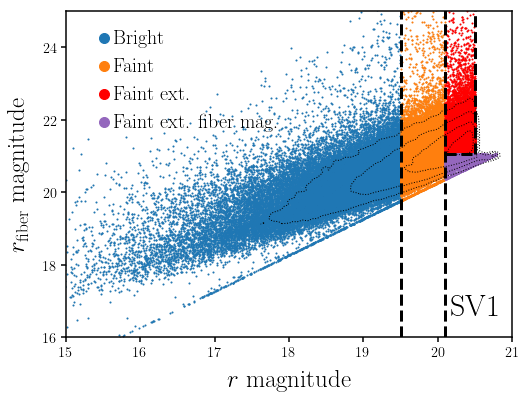

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

DFM.hist2d(rmag_S[is_gal_S & sv1_all], rfib_S[is_gal_S & sv1_all], 
           range=[(14, 21), (16, 26)], color='k', 
           plot_density=False, plot_datapoints=True, no_fill_contours=True, 
           bins=200, smooth=True, 
           contour_kwargs={'linewidths': 1, 'linestyles': ':'}, 
           ax=sub)

sub.scatter(rmag_S[is_gal_S & sv1_bright], rfib_S[is_gal_S & sv1_bright], s=1, c='C0', rasterized=True, label='Bright')
sub.scatter(rmag_S[is_gal_S & sv1_faint], rfib_S[is_gal_S & sv1_faint], s=1, c='C1', rasterized=True, label='Faint')
sub.scatter(rmag_S[is_gal_S & sv1_faint_ext], rfib_S[is_gal_S & sv1_faint_ext], s=1, c='r', rasterized=True, label='Faint ext.')
sub.scatter(rmag_S[is_gal_S & sv1_faint_fibmag], rfib_S[is_gal_S & sv1_faint_fibmag], s=1, c='C4', rasterized=True, label='Faint ext. fiber mag.')

sub.legend(loc='upper left', fontsize=20, handletextpad=-0.5, markerscale=10)
# hb = sub.hexbin(rmag_S[sv1_all], rfib_S[sv1_all], 
#                 C=np.ones(np.sum(sv1_all))/47, 
#                 reduce_C_function=np.sum, extent=(14, 21, 16, 26), gridsize=30, 
#                 edgecolors='k', linewidth=1., mincnt=2, cmap='Spectral_r')
# sub.text(0.05, 0.95, r'SV1', ha='left', va='top', transform=sub.transAxes, fontsize=30)

# sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
# sub.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=3)

sub.plot([19.5, 19.5], [16., 26], c='k', ls='--', lw=3)
sub.plot([20.1, 20.1], [16., 26], c='k', ls='--', lw=3)
sub.plot([20.1, 20.5], [21.051, 21.051], c='k', ls='--', lw=3)
sub.plot([20.5, 20.5], [21.051, 26.0], c='k', ls='--', lw=3)

sub.text(0.975, 0.05, r'SV1', ha='right', va='bottom', transform=sub.transAxes, fontsize=30)

sub.set_xlim(15, 21)
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])
#sub.set_yticklabels([])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$r$ magnitude', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'$r_{\rm fiber}$ magnitude', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.1, right=0.8)


fig.savefig('figs/sv1_targets.pdf', bbox_inches='tight')

In [16]:
targetclass = np.repeat(-1, np.sum(is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)))
targetclass[sv1_bright[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)]] = 0
targetclass[sv1_faint[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)]] = 1
targetclass[sv1_faint_ext[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)]] = 2
targetclass[sv1_faint_fibmag[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)]] = 3
assert np.sum(targetclass == -1) == 0

np.savetxt('dat/fig20_sv1targets.dat', 
           np.vstack([rmag_S[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)], rfib_S[is_gal_S & (sv1_bright | sv1_faint | sv1_faint_ext | sv1_faint_fibmag)], targetclass.astype(int)]).T, 
           fmt='%f %f %i', header='SV1 targets (targetclass={0: BGS Bright, 1: BGS Faint, 2: BGS Faint ext., 3: BGS Faint ext. fibmag})\n r magnitude, r_fiber magnitude, targetclass')